In [1]:
from ipywidgets import Image, Button, interact, ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import MultiCanvas, hold_canvas
from math import pi
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
import joblib

from deskew import deskew

kernel_svm = joblib.load('mnist_rbf_svm_model.pkl')

In [2]:
canvas = MultiCanvas(3, width=450, height=450, sync_image_data=True)

background_layer = canvas[0]
drawing_layer = canvas[1]
interaction_layer = canvas[2]

drawing = False

def draw_circle(canvas, point, radius):
    canvas.fill_arc(point[0], point[1], radius, 0, 2 * pi)

def on_mouse_down(x, y):
    global drawing
    if not drawing:
        draw_circle(interaction_layer, (x, y), radius_slider.value)    
        drawing = True

radius_slider = IntSlider(description='Radius:', value=15, min=5, max=30)

def on_mouse_move(x, y):
    if not drawing:
        return

    with hold_canvas(canvas):
        draw_circle(interaction_layer, (x, y), radius_slider.value)
        
def on_mouse_up(x, y):
    global drawing
    if drawing:
        drawing_layer.draw_image(interaction_layer, 0, 0)
        interaction_layer.clear()
        drawing = False

interaction_layer.on_mouse_down(on_mouse_down)
interaction_layer.on_mouse_move(on_mouse_move)
interaction_layer.on_mouse_up(on_mouse_up)

background_layer.stroke_rect(0, 0, 450, 450)

drawing_layer.fill_style = '#000000'
interaction_layer.fill_style = '#000000'

clear_button = Button(description='Clear Image')
clear_button.on_click(lambda x: drawing_layer.clear())

AppLayout(center=canvas, footer=HBox((radius_slider, clear_button)))


AppLayout(children=(HBox(children=(IntSlider(value=15, description='Radius:', max=30, min=5), Button(descripti…

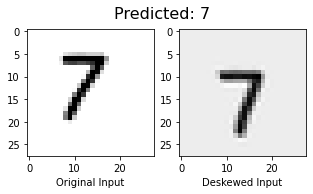

In [6]:
raw_img = drawing_layer.get_image_data(1, 1, 448, 448)

test_img = []
area_value = 0
for test_line in range(28):
    for test_row in range(28):
        for area_line in range(16):
            area_value = np.count_nonzero(raw_img[16 * test_line + area_line][test_row * 16:test_row * 16 + 16],
                                       axis=0)[3] + area_value
        if area_value == 256:
            area_value = 255
        test_img.append(area_value)
        area_value = 0

plt.figure(figsize=(5, 2.5))
deskewed_array = deskew((np.array(test_img)/255.0).reshape(28, 28))
prediction = kernel_svm.predict([deskewed_array.reshape(784)])[0]
img = plt.subplot(1, 2, 1)
img.set_xlabel('Original Input')
img.imshow(np.array(test_img).reshape(28, 28), cmap=plt.cm.binary)
img_deskew = plt.subplot(1, 2, 2)
img_deskew.set_xlabel('Deskewed Input')
img_deskew.imshow(deskewed_array, cmap=plt.cm.binary)
plt.suptitle('Predicted: %d' % prediction, fontsize=16)
plt.show()